# 1. Loading Data 

In [1]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import COLORS_MODELS, PROCESSED_DIR, PROTEIN_IDS_CSV, get_paths_protein, get_paths
from __future__ import unicode_literals
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import importlib
import matplotlib.patheffects as path_effects



# For Statistics
import statsmodels.api as sm
from scipy.stats import normaltest, skew, kurtosis, anderson, levene, kruskal
import scikit_posthocs as sp


# Setting the path to utils.py
os.chdir('/Users/doma/Documents/Bachelor_Arbeit/Code') # Change to the directory where the code is located
print(os.getcwd())  # Confirm it changed
import src.utils as utils

# Reload the module to reflect the latest changes or RESTART the KERNEL
importlib.reload(utils)

# Now you should see the updated functions
print(dir(utils))

# Set plotting style
plt.style.use('seaborn-v0_8-white')  # Corrected style
sns.set_style("whitegrid")  # Use sns to set a Seaborn style
FONTSIZE="xx-large"
COLORS = cm.viridis(np.linspace(0.4, 1, 7))



/Users/doma/Documents/Bachelor_Arbeit/Code
['Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'compute_highlight_regions', 'get_project_paths', 'group_by_pred_class', 'load_dotenv', 'os', 'pd', 'save_csv_no_overwrite']


In [2]:
# Load the data
df = pd.read_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Human_N_Out_Proteome_TMD_pathogenicity.csv')
df.head(4)

,entry,name,gene_name,PRED_MEAN [%],PRED_STD [%],dataset,class,pred_class,new_hc_substrate,substrate_homolog,...,Start_11AA,End_11AA,TMD_start,TMD_end,avg_pathogenicity_11AA_AlphaMissense,Start_40AA,End_40AA,avg_pathogenicity_40AA_AlphaMissense,avg_pathogenicity_11AA_ESM1b,avg_pathogenicity_40AA_ESM1b
0,P16150,LEUK_HUMAN,SPN,95.22,2.02,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,270.0,280.0,254.0,276.0,0.535981,244.0,286.0,0.475119,-10.271659,-8.849636
1,P28827,PTPRM_HUMAN,PTPRM,94.79,2.09,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,758.0,768.0,743.0,764.0,0.736355,733.0,774.0,0.680331,-13.848632,-13.563631
2,P10586,PTPRF_HUMAN,PTPRF,94.64,2.03,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,1278.0,1288.0,1264.0,1284.0,0.832472,1254.0,1294.0,0.709868,-11.871359,-10.520926
3,Q06418,TYRO3_HUMAN,TYRO3,94.49,2.14,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,444.0,454.0,430.0,450.0,0.586902,420.0,460.0,0.526596,-7.661459,-7.461549


In [138]:
# Get each pred_class group as dictionary df_grouped
df_grouped = utils.group_by_pred_class(df)

# Access individual groups like this:
df_grouped['HC substrate'].head(4)

,entry,name,gene_name,PRED_MEAN [%],PRED_STD [%],dataset,class,pred_class,new_hc_substrate,substrate_homolog,...,Start_11AA,End_11AA,TMD_start,TMD_end,avg_pathogenicity_11AA_AlphaMissense,Start_40AA,End_40AA,avg_pathogenicity_40AA_AlphaMissense,avg_pathogenicity_11AA_ESM1b,avg_pathogenicity_40AA_ESM1b
0,P16150,LEUK_HUMAN,SPN,95.22,2.02,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,270.0,280.0,254.0,276.0,0.535981,244.0,286.0,0.475119,-10.271659,-8.849636
1,P28827,PTPRM_HUMAN,PTPRM,94.79,2.09,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,758.0,768.0,743.0,764.0,0.736355,733.0,774.0,0.680331,-13.848632,-13.563631
2,P10586,PTPRF_HUMAN,PTPRF,94.64,2.03,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,1278.0,1288.0,1264.0,1284.0,0.832472,1254.0,1294.0,0.709868,-11.871359,-10.520926
3,Q06418,TYRO3_HUMAN,TYRO3,94.49,2.14,SUBEXPERT,SS_TYPE1,HC substrate,0,1,...,444.0,454.0,430.0,450.0,0.586902,420.0,460.0,0.526596,-7.661459,-7.461549


# 2. Plotting

Here is the design for the plots from: https://alexgude.com/blog/distribution-plots/    

### 2.1 Definition of the plotting function

In [392]:
# Ensure palette is a list and matches the number of unique categories
unique_classes = df["pred_class"].nunique()
COLORS = list(COLORS)[:unique_classes]


def make_plot_with_means(
    plot_function,
    title,
    file_name,
    invert,
    llr,
    means,
    x,
    y,
    data,
    invert_y=False,
    subtitle=None,
    background_color="white",
    palette=None,
    n=False,
    model=None,
    **kwargs
):
    # Create the figure and set the background color
    fig = plt.gcf()
    fig.set_size_inches(14, 8)  # Adjust aspect ratio
    fig.patch.set_facecolor(background_color)  # Set background color

    # Create the plot
    ax = plot_function(x=x, y=y, data=data, palette=palette, **kwargs)

    # Add title and axis labels
    plt.title(title, y=1.03, size=24, fontweight='bold')
    plt.ylabel("Average Pathogenicity " + llr, fontsize=16, fontweight='bold')
    plt.xlabel("Prediction Class", fontsize=16, fontweight='bold')

    # Add an optional subtitle
    if subtitle:
        plt.suptitle(subtitle, y=0.98, fontsize=18, fontweight='medium', color='gray')

    # Customize tick labels
    ax.tick_params(axis='x', labelsize=14, rotation=0)
    ax.tick_params(axis='y', labelsize=14)

    # Add major and minor gridlines
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, color='lightgray', alpha=0.5)

    # Optional: Invert the y-axis if requested
    if invert_y:
        ax.invert_yaxis()

    # Disable the gridlines
    ax.grid(False)  # This removes all gridlines

    # Ensure the order of means matches the order of boxplots
    ordered_classes = [tick.get_text() for tick in ax.get_xticklabels()]

    if means:
        # Add mean values as text annotations
        group_means = data.groupby(x)[y].mean()

        # Ensure the order of means matches the order of boxplots
        #ordered_classes = [tick.get_text() for tick in ax.get_xticklabels()]
        ordered_means = group_means.loc[ordered_classes]

        for i, mean in enumerate(ordered_means):
            ax.text(
                i,
                mean + invert,  # Adjust the offset for better positioning
                f'{mean:.3f}',
                color='white',
                ha='center',
                va='top',
                fontsize=16,  # Increased font size for better visibility
                fontweight='bold',
                alpha=1,
                path_effects=[path_effects.withStroke(linewidth=1, foreground="black")]  # Add stroke for better sharpness
            )
    if n:
        # Add number of data points per group
        group_counts = data.groupby(x)[y].count()

        # Ensure the order of counts matches the order of boxplots
        ordered_counts = group_counts.loc[ordered_classes]
        
        # Add number of data points per group
        for i, count in enumerate(ordered_counts):
            # Dynamically adjust offset based on the y-axis limits
            ymin, ymax = ax.get_ylim()  # Get the current y-axis limits
            if model == "AlphaMissense":
                offset = -1.65
            else:
                offset = ymin - (ymax - ymin) * 0.07 # 2% above the bottom of the y-axis
            
            ax.text(
                i,
                offset,  # Adjusted position relative to the y-axis limits
                f'n={count}',
                color='black',
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='bold',
                alpha=0.8
            )


    # Define the save path based on the plot function
    if plot_function == sns.swarmplot:
        save_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/results/images/Swarmplots/'
    elif plot_function == sns.boxplot:
        save_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/results/images/Boxplots/'


    # Save the plot with dynamic file naming
    plt.tight_layout()  # Ensure everything fits well
    plt.savefig(save_path + file_name + ".png", dpi=300, bbox_inches='tight')
    plt.savefig(save_path + file_name + ".svg", dpi=300, bbox_inches='tight')

    # Return the Axes object
    return ax

### 2.2 Real Boxplot Plotting Here

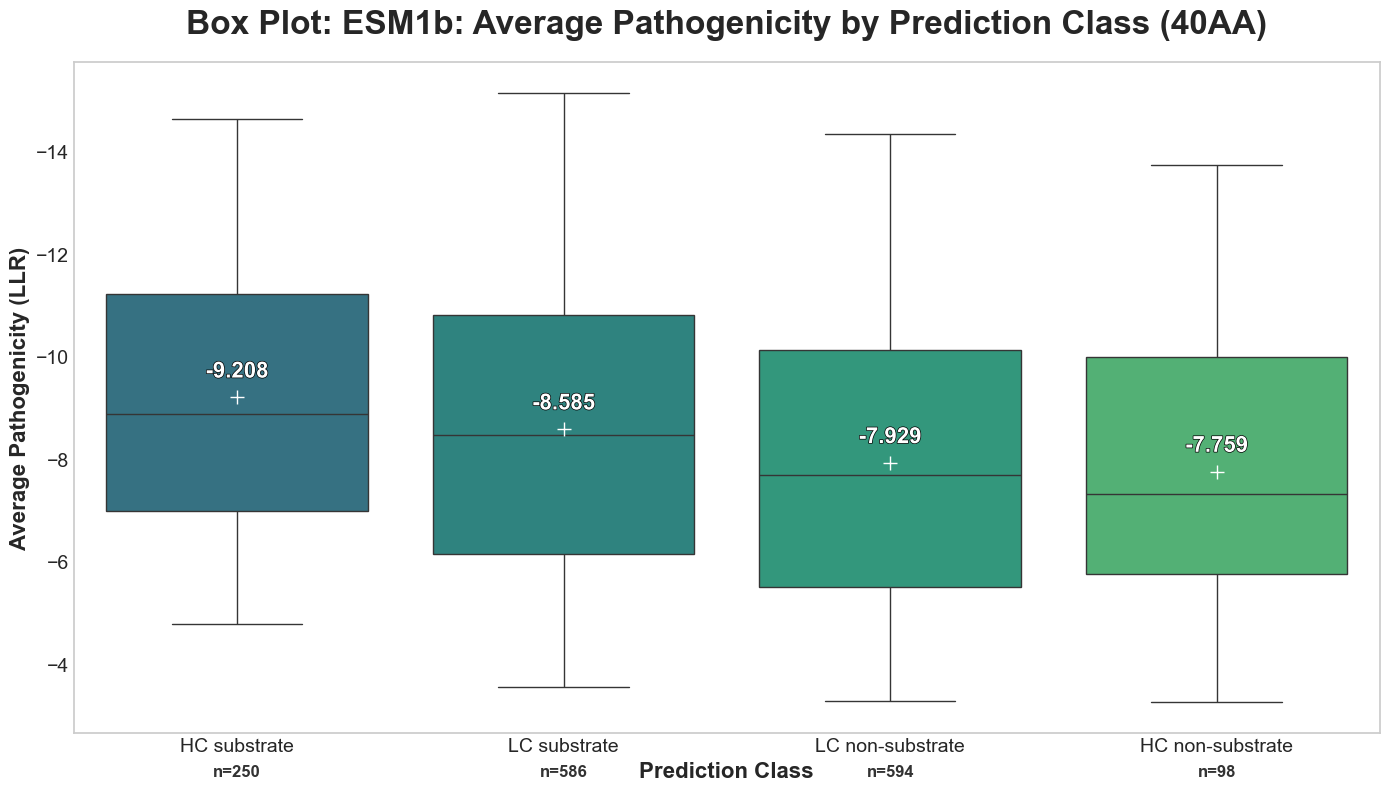

In [390]:
# Set plot specifications
model = "ESM1b"  # ESM1b or AlphaMissense
region = "40AA"  # 40AA or 11AA



# Determine invert_y based on the model
if model == "ESM1b":
    invert_y = True  # Invert the y-axis
    invert = - 0.7
    llr = "(LLR)"
elif model == "AlphaMissense":
    invert_y = False  # Do not invert the y-axis
    invert = 0.05
    llr = "(Normalized)"



# Call the function
ax = make_plot_with_means(
    plot_function=sns.boxplot,
    title="Box Plot: " + model + ": Average Pathogenicity by Prediction Class " + '(' + region + ')',
    file_name="boxplot_avg_pathogenicity_" + model + '_' + region,
    invert = invert,
    llr = llr,
    means = True,
    x="pred_class",
    y="avg_pathogenicity_" + region + "_" + model,
    data=df,
    invert_y=invert_y,  # Pass the invert_y value
    background_color="white",
    palette=COLORS,  # Use the predefined COLORS list
    n = True,
    hue="pred_class",  # Assign x variable to hue
    dodge=False,       # Prevent splitting by hue
    showmeans=True,    # Show means
    meanprops={"marker": "+",
               "markeredgecolor": "white",
               "markersize": "10"}
)


### 2.3 Real Swarm Plotting Here

<Axes: title={'center': 'Swarm Plot: ESM1b: Average Pathogenicity by Prediction Class (40AA)'}, xlabel='Prediction Class', ylabel='Average Pathogenicity (LLR)'>

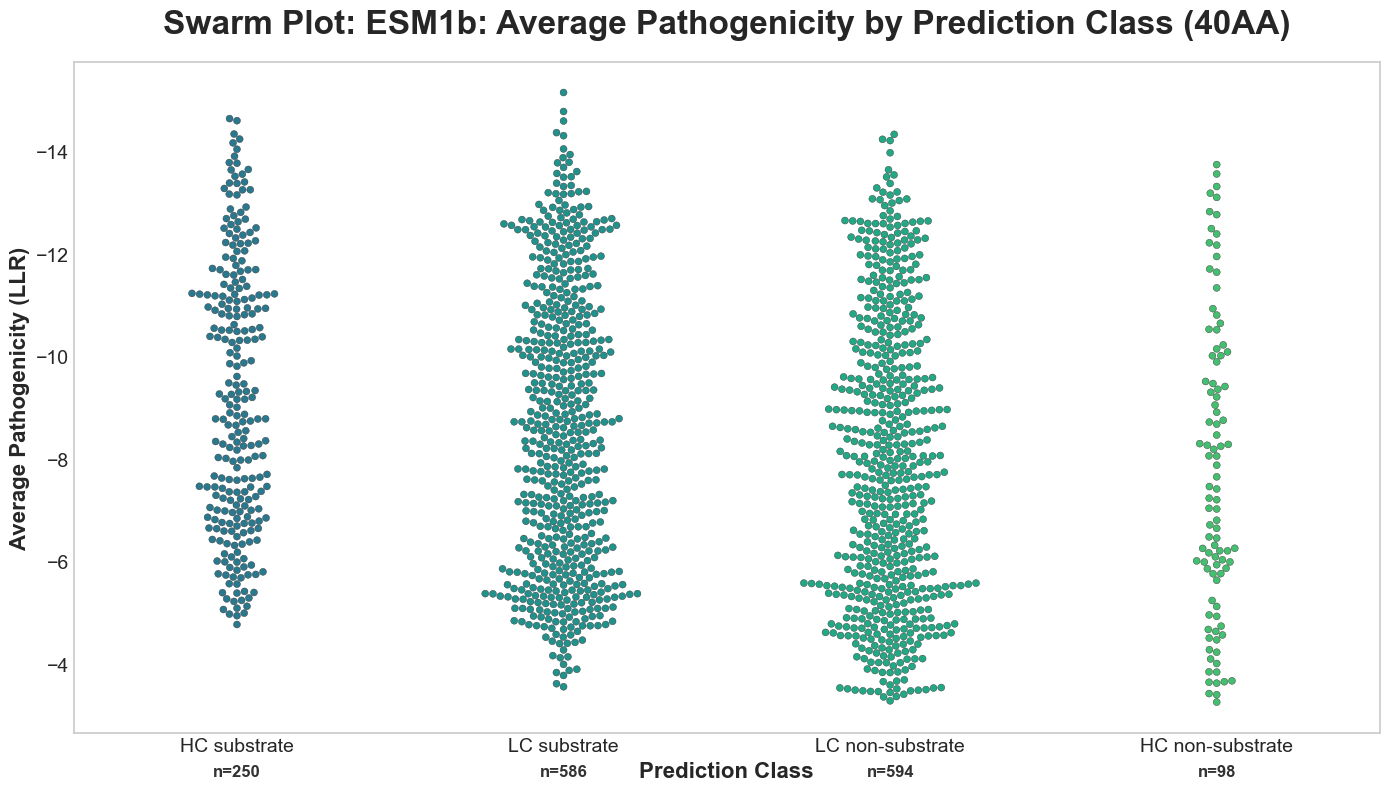

In [397]:
# Set plot specifications
model = "ESM1b"  # ESM1b or AlphaMissense
region = "40AA"  # 40AA or 11AA

# Determine invert_y based on the model
if model == "ESM1b":
    invert_y = True  # Invert the y-axis
    invert = - 0.7
    llr = "(LLR)"
elif model == "AlphaMissense":
    invert_y = False  # Do not invert the y-axis
    invert = 0.05
    llr = "(Normalized)"

make_plot_with_means(
    plot_function = sns.swarmplot,
    title="Swarm Plot: " + model + ": Average Pathogenicity by Prediction Class " + '(' + region + ')',
    file_name="Swarmplot_avg_pathogenicity_" + model + '_' + region,
    invert = invert,
    llr = llr,
    means = False,
    x="pred_class",
    y="avg_pathogenicity_" + region + "_" + model,
    data=df,
    invert_y=invert_y,  # Pass the invert_y value
    palette=COLORS,
    n=True,
    #size=7,               # Adjust marker size
    linewidth=0.3,        # Adjust marker edge width
    #edgecolor="black",     # Set marker edge color
    #alpha=0.8,            # Set transparency of markers
    hue="pred_class",     # Assign x variable to hue
    dodge=False,           # Separate points by hue
    legend=False,          # Display legend
    #marker="o",           # Change marker style
    zorder=0              # Set z-order for layering
)


# 3. Statistical Analysis of the Groups
- 1. 1 categorical + 1 quantitative (average_pathogenicity)
- 2. 4 groups
- 3. independent
- 4. Parametric / non-parametric

Parametricity
- Are normally distributed - 
  - numerical tests says not normally distributed NOT OK
  - QQ-plots, histograms, qqplot OK 
- Variances equal between groups? use Levene's test
- Groups unequal in sizes? yes = NOT OK
- As groups are very different in the size of datapoints (550, to 100)
- 
  
- We need to check if each group is normally distributed



## 3.1 Check the Normality graphically

In [562]:
def plot_grouped_visualizations(data, y_column):
    """
    Plots histograms, QQ plots, and boxplots for each group in the 'pred_class' column.

    Parameters:
        data (pd.DataFrame): The input dataset containing the 'pred_class' column and the y_column.
        y_column (str): The column name to be used for plotting (e.g., "avg_pathogenicity_40AA_ESM1b").
    """
    # Ensure 'pred_class' exists in the dataset
    if "pred_class" not in data.columns:
        raise ValueError("The dataset must contain a 'pred_class' column.")

    # Ensure the y_column exists in the dataset
    if y_column not in data.columns:
        raise ValueError(f"The dataset must contain the column '{y_column}'.")

    # Define the group labels for the rows
    row_labels = ["HC substrate", "LC substrate", "LC non-substrate", "HC non-substrate"]

    # Ensure the number of groups matches the row labels
    groups = data["pred_class"].unique()
    if len(groups) != len(row_labels):
        raise ValueError("The number of unique groups in 'pred_class' must match the number of row labels.")

    # Set up the figure layout
    num_groups = len(groups)
    fig, axes = plt.subplots(num_groups, 3, figsize=(12, 3 * num_groups), gridspec_kw={'width_ratios': [1, 1, 1]})

    # Add column headers (Histogram, QQ-Plot, Boxplot) at the top
    column_headers = ["Histogram", "QQ-Plot", "Boxplot"]
    for j, header in enumerate(column_headers):
        axes[0, j].annotate(
            header,
            xy=(0.5, 1.1),  # Position above the plot
            xycoords='axes fraction',
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='bottom'
        )

    # Iterate over each group
    for i, (group, row_label) in enumerate(zip(groups, row_labels)):
        group_data = data[data["pred_class"] == group][y_column].dropna()

        # Add row labels (e.g., HC substrate, LC substrate, etc.) on the leftmost side
        axes[i, 0].annotate(
            row_label,
            xy=(-0.2, 0.5),  # Position to the left of the row
            xycoords='axes fraction',
            fontsize=14,
            fontweight='bold',
            ha='right',
            va='center',
            rotation=90
        )

        # Histogram
        sns.histplot(group_data, kde=True, ax=axes[i, 0], color="skyblue")
        axes[i, 0].set_title("")
        axes[i, 0].set_xlabel("Average Pathogenicity (LLR)", fontsize=12)
        axes[i, 0].set_ylabel("Frequency", fontsize=12)

        # QQ Plot
        sm.qqplot(group_data, line="s", ax=axes[i, 1])
        axes[i, 1].set_title("")
        axes[i, 1].set_xlabel("Theoretical Quantiles", fontsize=12)
        axes[i, 1].set_ylabel("Sample Quantiles", fontsize=12)

        # Boxplot
        sns.boxplot(x=group_data, ax=axes[i, 2], color="lightgreen")
        axes[i, 2].set_title("")
        axes[i, 2].set_xlabel("", fontsize=12)
        axes[i, 2].set_ylabel("")

    # Adjust layout
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])

    # Save the figure
    save_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/results/images/Statistics/'
    plt.savefig(save_path + f"Normality_{y_column}.png", dpi=300, bbox_inches='tight')

    plt.show()

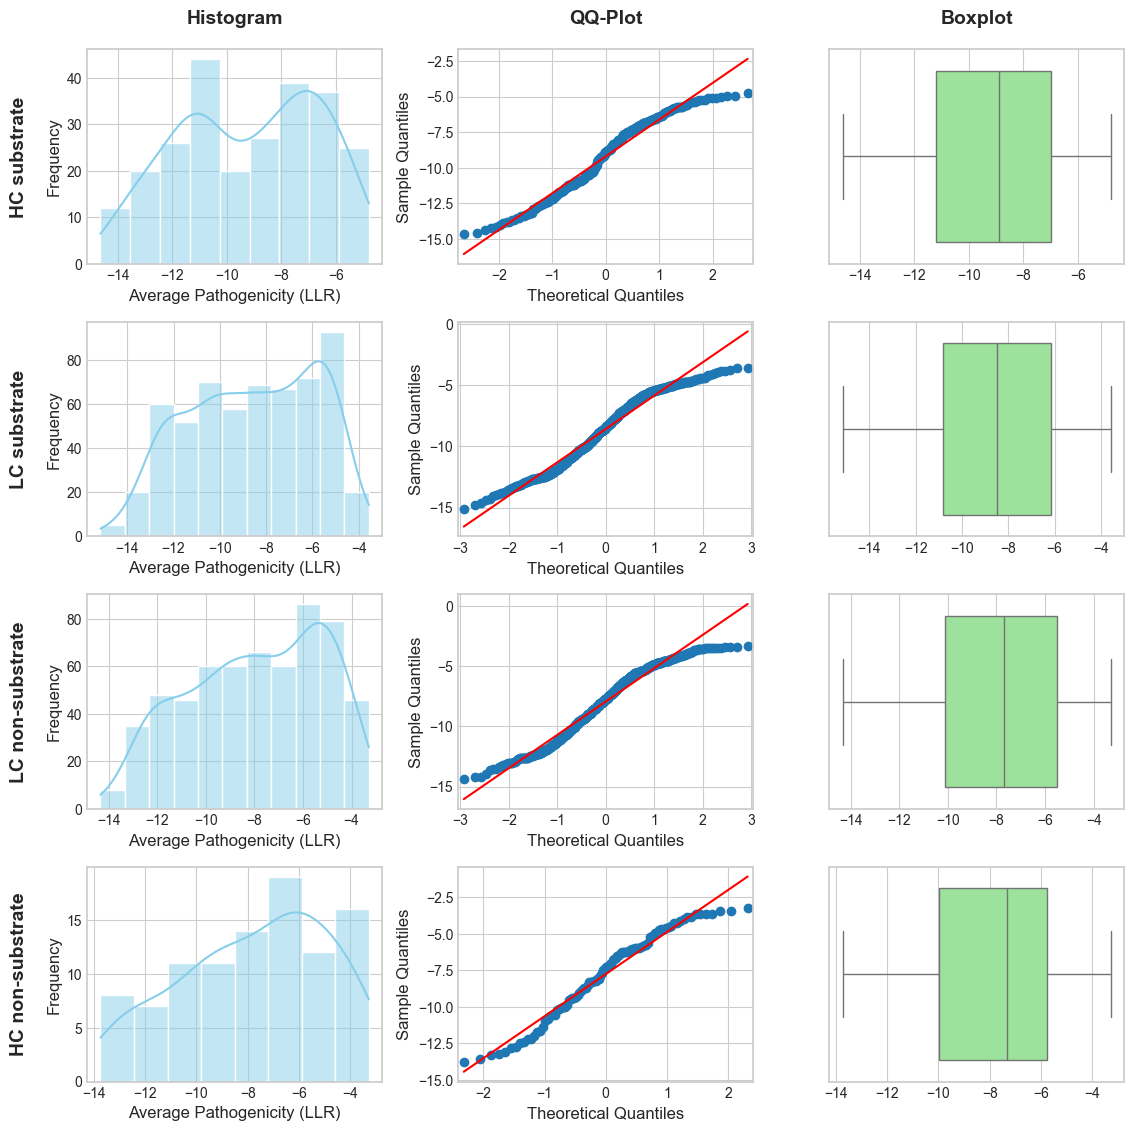

In [585]:
plot_grouped_visualizations(df, "avg_pathogenicity_40AA_ESM1b")

## 3.2 Check Normality numerically

### Check for Normality with scipy.stats.normaltest for small groups (HC substrate and non-substrate)

In [533]:
def analyze_group_normality(df, model, region, group):
    
    # Get each pred_class group as dictionary df_grouped
    df_grouped = utils.group_by_pred_class(df)

    # group = HC non-substrate, LC non-substrat, LC substrate, HC substrate	

    model_region = region + '_' + model
    model1 = 'avg_pathogenicity_' + model_region
    data = df_grouped[group][model1].dropna()

    normality_data ={}

    # Calculate skewness and kurtosis and assign to normality_data
    normality_data['skewness'] = float(round(skew(data), 4))
    normality_data['kurtosis'] = float(round(kurtosis(data), 4))

    # Calculate number of data points
    normality_data['n'] = len(data)

    skewness = float(skew(data))
    kurt = float(kurtosis(data))

    # Perform normality test using scipy.stats.normaltest
    test_statistic, p_value = normaltest(data)
    normality_data['test_statistic'] = float(round(test_statistic, 4))
    normality_data['p_value'] = float(round(p_value, 4))




    '''
    # Print the results
    print("Skewness:", round(skewness, 4))
    print("Kurtosis:", round(kurt, 4))
    print("Test statistic:", round(test_statistic, 4))
    print("P-value:", round(p_value, 4))
    print("Number of data points:", len(data))
    '''



    
    # Determine normality based on p-value
    if p_value < 0.05:
        #print("Data is likely not normally distributed ❌")
        normality_data['normality'] = False
        
    else:
        #print("Data is likely normally distributed ✅")
        normality_data['normality'] = True

    return normality_data

In [538]:
normality_groups = {}
group = ["LC substrate", "LC non-substrate"]     # group = HC non-substrate, LC non-substrat, LC substrate, HC substrate	
model = ["AlphaMissense", "ESM1b"]                      # ESM1b or AlphaMissense
region = ["40AA", "11AA"]  

# Define the desired column order
desired_column_order = ['model', 'region', 'group', 'n', 'skewness', 'kurtosis', 'normality']


# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over every group, model, and region and store the results nicely in a Pandas DataFrame
for g in group:
    for m in model:
        for r in region:
            # Analyze normality for the current combination of group, model, and region
            normality_data = analyze_group_normality(df, model=m, region=r, group=g)
            normality_data['model'] = m
            normality_data['region'] = r
            normality_data['group'] = g

            # Append the results to the dictionary
            normality_groups[g] = normality_data

            # Convert the dictionary to a DataFrame row and append it to the results DataFrame
            results_df = pd.concat([results_df, pd.DataFrame([normality_data])], ignore_index=True)

# Reorder the columns in the DataFrame
results_df = results_df[desired_column_order]

results_df.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Normality_test_results_small_groups.csv', index=False)

### Analyse Normality with Shapiro-Wilk test

In [578]:
# Helper function for normality testing using Shapiro-Wilk
def analyze_group_normality_shapiro(df, model, region, group):
    """
    Analyze the normality of a specific group in the dataset using the Shapiro-Wilk test.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        model (str): The model name (e.g., "ESM1b").
        region (str): The region name (e.g., "40AA").
        group (str): The group name (e.g., "HC substrate").

    Returns:
        dict: A dictionary containing normality statistics and test results.
    """
    # Get each pred_class group as dictionary df_grouped
    df_grouped = utils.group_by_pred_class(df)

    # Construct the column name for the model and region
    model_region = region + '_' + model
    model1 = 'avg_pathogenicity_' + model_region

    # Extract the data for the specific group and drop NaN values
    data = df_grouped[group][model1].dropna()

    # Initialize the dictionary to store normality data
    normality_data = {}

    # Calculate skewness and kurtosis
    normality_data['skewness'] = float(round(skew(data), 4))
    normality_data['kurtosis'] = float(round(kurtosis(data), 4))

    # Calculate the number of data points
    normality_data['n'] = len(data)

    # Perform the Shapiro-Wilk test for normality
    test_statistic, p_value = shapiro(data)
    normality_data['test_statistic'] = float(round(test_statistic, 4))
    normality_data['p_value'] = float(round(p_value, 4))

    # Determine normality based on tvhe Shapiro-Wilk test
    # If p-value < 0.05, the data is not normally distributed
    if p_value < 0.05:
        normality_data['normality'] = False  # Data is not normally distributed
    else:
        normality_data['normality'] = True  # Data is normally distributed

    return normality_data

In [ ]:

group = ["HC substrate", "HC non-substrate", "LC substrate", "LC non-substrate"]     # group = HC non-substrate, LC non-substrat, LC substrate, HC substrate	
model = ["AlphaMissense", "ESM1b"]                      # ESM1b or AlphaMissense
region = ["40AA", "11AA"]                             # 40AA or 11AA

# Define the desired column order
desired_column_order_anderson = ['model', 'region', 'group', 'n', 'skewness', 'kurtosis', 'test_statistic', 'critical_values', 'normality']
desired_column_order_shapiro = ['model', 'region', 'group', 'n', 'skewness', 'kurtosis', 'test_statistic', 'p_value', 'normality']

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over every group, model, and region and store the results nicely in a Pandas DataFrame
for g in group:
    for m in model:
        for r in region:
            # Analyze normality for the current combination of group, model, and region
            normality_data = analyze_group_normality_shapiro(df, model=m, region=r, group=g)
            normality_data['model'] = m
            normality_data['region'] = r
            normality_data['group'] = g
            
            

            # Append the results to the dictionary
            normality_groups[g] = normality_data
          
            # Convert the dictionary to a DataFrame row and append it to the results DataFrame
            results_df = pd.concat([results_df, pd.DataFrame([normality_data])], ignore_index=True)

# Reorder the columns in the DataFrame
results_df = results_df[desired_column_order_shapiro]

# Display the final DataFrame
results_df.head(10)

results_df.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Normality_test_results_shapiro.csv', index=False)

### Analyse normality with Anderson-Darling test

In [ ]:
def analyze_group_normality_anderson(df, model, region, group):
    """
    Analyze the normality of a specific group in the dataset using the Anderson-Darling test.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        model (str): The model name (e.g., "ESM1b").
        region (str): The region name (e.g., "40AA").
        group (str): The group name (e.g., "HC substrate").

    Returns:
        dict: A dictionary containing normality statistics and test results.
    """
    # Get each pred_class group as dictionary df_grouped
    df_grouped = utils.group_by_pred_class(df)

    # Construct the column name for the model and region
    model_region = region + '_' + model
    model1 = 'avg_pathogenicity_' + model_region

    # Extract the data for the specific group and drop NaN values
    data = df_grouped[group][model1].dropna()

    # Initialize the dictionary to store normality data
    normality_data = {}

    # Calculate skewness and kurtosis
    normality_data['skewness'] = float(round(skew(data), 4))
    normality_data['kurtosis'] = float(round(kurtosis(data), 4))

    # Calculate the number of data points
    normality_data['n'] = len(data)

    # Perform the Anderson-Darling test for normality
    anderson_result = anderson(data, dist='norm')
    normality_data['test_statistic'] = float(round(anderson_result.statistic, 4))
    normality_data['critical_values'] = [float(round(cv, 4)) for cv in anderson_result.critical_values]
    normality_data['significance_levels'] = [float(round(sl, 4)) for sl in anderson_result.significance_level]

    # Determine normality based on the Anderson-Darling test
    # Compare the test statistic with the critical value at the 5% significance level
    critical_value_5_percent = anderson_result.critical_values[2]  # 5% significance level is typically the third value
    if anderson_result.statistic > critical_value_5_percent:
        normality_data['normality'] = False  # Data is not normally distributed
    else:
        normality_data['normality'] = True  # Data is normally distributed

    return normality_data

In [583]:

group = ["HC substrate", "HC non-substrate", "LC substrate", "LC non-substrate"]     # group = HC non-substrate, LC non-substrat, LC substrate, HC substrate	
model = ["AlphaMissense", "ESM1b"]                      # ESM1b or AlphaMissense
region = ["40AA", "11AA"]                             # 40AA or 11AA

# Define the desired column order
desired_column_order_anderson = ['model', 'region', 'group', 'n', 'skewness', 'kurtosis', 'test_statistic', 'critical_values', 'normality']
desired_column_order_shapiro = ['model', 'region', 'group', 'n', 'skewness', 'kurtosis', 'test_statistic', 'p_value', 'normality']

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over every group, model, and region and store the results nicely in a Pandas DataFrame
for g in group:
    for m in model:
        for r in region:
            # Analyze normality for the current combination of group, model, and region
            normality_data = analyze_group_normality_anderson(df, model=m, region=r, group=g)
            normality_data['model'] = m
            normality_data['region'] = r
            normality_data['group'] = g
            
            

            # Append the results to the dictionary
            normality_groups[g] = normality_data
          
            # Convert the dictionary to a DataFrame row and append it to the results DataFrame
            results_df = pd.concat([results_df, pd.DataFrame([normality_data])], ignore_index=True)

# Reorder the columns in the DataFrame
results_df = results_df[desired_column_order_anderson]

# Display the final DataFrame
results_df.head(10)

results_df.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Normality_test_results_anderson.csv', index=False)

### Analyse normality with skewness and kurtosis for large groups

**scipy.stats.normaltest**

This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis to produce an omnibus test of normality

In [ ]:
def analyze_large_group_normality(df, model, region, group):
    df_grouped = utils.group_by_pred_class(df)
    model_region = region + '_' + model
    model1 = 'avg_pathogenicity_' + model_region
    data = df_grouped[group][model1].dropna()

    normality_data = {}
    normality_data['skewness'] = float(round(skew(data), 4))
    normality_data['kurtosis'] = float(round(kurtosis(data), 4))  # this is excess kurtosis
    normality_data['n'] = len(data)

    # Apply thresholds for large samples
    is_skew_ok = abs(normality_data['skewness']) <= 2
    is_kurt_ok = abs(normality_data['kurtosis']) <= 4

    normality_data['normality'] = is_skew_ok and is_kurt_ok

    return normality_data


In [541]:
normality_groups = {}
group = ["LC substrate", "LC non-substrate"]     # group = HC non-substrate, LC non-substrat, LC substrate, HC substrate	
model = ["AlphaMissense", "ESM1b"]                      # ESM1b or AlphaMissense
region = ["40AA", "11AA"]  

# Define the desired column order
desired_column_order = ['model', 'region', 'group', 'n', 'skewness', 'kurtosis', 'normality']


# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

# Iterate over every group, model, and region and store the results nicely in a Pandas DataFrame
for g in group:
    for m in model:
        for r in region:
            # Analyze normality for the current combination of group, model, and region
            normality_data = analyze_large_group_normality(df, model=m, region=r, group=g)
            normality_data['model'] = m
            normality_data['region'] = r
            normality_data['group'] = g

            # Append the results to the dictionary
            normality_groups[g] = normality_data

            # Convert the dictionary to a DataFrame row and append it to the results DataFrame
            results_df = pd.concat([results_df, pd.DataFrame([normality_data])], ignore_index=True)

# Reorder the columns in the DataFrame
results_df = results_df[desired_column_order]

results_df.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Normality_test_results_large_groups.csv', index=False)

In [485]:
df.groupby("pred_class")["avg_pathogenicity_40AA_ESM1b"].describe()

,count,mean,std,min,25%,50%,75%,max
pred_class,,,,,,,,
HC non-substrate,98.0,-7.758842,2.889052,-13.749916,-9.990694,-7.332488,-5.768116,-3.263765
HC substrate,250.0,-9.207545,2.587940,-14.646988,-11.221260,-8.892416,-6.982629,-4.777752
LC non-substrate,594.0,-7.929049,2.772605,-14.340257,-10.132191,-7.703127,-5.505619,-3.288234
LC substrate,586.0,-8.585390,2.723984,-15.156066,-10.812484,-8.468915,-6.149129,-3.563465


### Levene's test for equal variances

In [627]:
# Define, initialize all necessary variables
group = ["HC substrate", "HC non-substrate", "LC substrate", "LC non-substrate"]  # Groups
model = ["AlphaMissense", "ESM1b"]  # Models
region = ["40AA", "11AA"]  # Regions
results_df = pd.DataFrame()






# Iterate over every model and region to perform Levene's test
for m in model:
    for r in region:
        # Construct the column name for the model and region
        model_region = r + '_' + m
        model1 = 'avg_pathogenicity_' + model_region

        # Extract data for all groups
        group_data = []
        for g in group:
            # Extract the data for the specific group and drop NaN values
            data = df[df['pred_class'] == g][model1].dropna()
            group_data.append(data)

        # Perform Levene's test for equal variances
        test_statistic, p_value = levene(*group_data)

        # Determine if variances are equal based on the p-value
        equal_variances = p_value >= 0.05  # True if p-value >= 0.05, else False

        # Store the results in a dictionary
        levene_data = {
            'model': m,
            'region': r,
            'test_statistic': round(test_statistic, 4),
            'p_value': round(p_value, 4),
            'equal_variances': equal_variances
        }

        # Convert the dictionary to a DataFrame row and append it to the results DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([levene_data])], ignore_index=True)



# Define the desired column order for Levene's test results and reorder columns
desired_column_order_levene = ['model', 'region', 'test_statistic', 'p_value', 'equal_variances']
results_df = results_df[desired_column_order_levene]

# Display the final DataFrame
print(results_df.head(10))

# Save the DataFrame to a CSV file
results_df.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Levene_test_results.csv', index=False)

           model region  test_statistic  p_value  equal_variances
0  AlphaMissense   40AA          0.1937   0.9007             True
1  AlphaMissense   11AA          0.4401   0.7244             True
2          ESM1b   40AA          0.5282   0.6629             True
3          ESM1b   11AA          1.8131   0.1428             True


### Kruskal-Wallis test

In [620]:
# Define, initialize all necessary variables
desired_column_order_kruskal = ['model', 'region', 'test_statistic', 'p_value', 'difference']
group = ["HC substrate", "HC non-substrate", "LC substrate", "LC non-substrate"]  # Groups
model = ["AlphaMissense", "ESM1b"] 
region = ["40AA", "11AA"]  
results_df = pd.DataFrame()


# Run Kruskal-Wallis test on 4 groups and this in 4 different scenarios
for m in model:
    for r in region:

        # Construct the column name for the model and region
        r_m = 'avg_pathogenicity_' + r + '_' + m

        # Compute kruskal statistics
        stat, pval = stats.kruskal(
            df[df['pred_class'] == group[0]][r_m].dropna(),     # access the value column of specific model and region
            df[df['pred_class'] == group[1]][r_m].dropna(),
            df[df['pred_class'] == group[2]][r_m].dropna(),
            df[df['pred_class'] == group[3]][r_m].dropna(),
            nan_policy='propagate'
        )
        
        # Determine if the null hypothesis can be rejected
        reject_null = pval < 0.05
        

        # Store the results in a dictionary
        kruskal_data = {
            'model': m,
            'region': r,
            'test_statistic': round(stat, 4),
            'p_value': round(pval, 4),
            'difference': reject_null
        }

        # Convert the dictionary to a DataFrame row and append it to the results DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([kruskal_data])], ignore_index=True)

        # Define the desired column order for Levene's test results and reorder columns
        results_df = results_df[desired_column_order_kruskal]



# Display the final DataFrame
print(results_df.head(10))

# Save the DataFrame to a CSV file
results_df.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/Kruskal_test_results.csv', index=False)

           model region  test_statistic  p_value  difference
0  AlphaMissense   40AA          8.4730   0.0372        True
1  AlphaMissense   11AA          3.9531   0.2666       False
2          ESM1b   40AA         46.0005   0.0000        True
3          ESM1b   11AA         48.2001   0.0000        True


### Run Post-Hoc Tests to find out what groups are different in each situation
- We know from Levenes test that there are no significant differences between variances in all groups
- Appropriate test after Kruskal is Dunn's Test: "https://www.theanalysisfactor.com/dunns-test-post-hoc-test-after-kruskal-wallis/"
- Dunn-fdr_bh Test
- Bonferroni - conservative
- 
If you're exploring data and can tolerate some false positives to not miss discoveries (e.g., in biological or social research)
→ Use Benjamini-Hochberg (FDR).

In [645]:
group = ["HC substrate", "LC substrate", "LC non-substrate", "HC non-substrate"] 

for m in model:
    for r in region:

        # Construct the column name for the model and region
        r_m = 'avg_pathogenicity_' + r + '_' + m
        
        # Run Dunn’s test (non-parametric pairwise with correction) = result is pandas df
        posthoc_dunn = sp.posthoc_dunn(df, val_col=r_m, group_col='pred_class', p_adjust='bonferroni', sort=False)
        
        # Reorder the rows and columns of the posthoc_dunn DataFrame to match the desired group order
        posthoc_dunn = posthoc_dunn.loc[group, group]

        # Save each posthoc dunn result in a separate CSV file
        posthoc_dunn.to_csv('/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/2. Statistics/Posthoc_/posthoc_dunn_' + r + '_' + m + '_bonferroni.csv', index=True)
        print(f"The posthoc dunn test for {r} and {m} is saved in the results folder")
        
        # Create a heatmap for Dunn's test results and save it
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        heatmap = sp.sign_plot(posthoc_dunn, **heatmap_args)
        
        # Save the heatmap plot
        heatmap_save_path = '/Users/doma/Documents/Bachelor_Arbeit/Code/results/csv/2. Statistics/Posthoc_/heatmap_posthoc_dunn_' + r + '_' + m + '_bonferroni.png'
        plt.savefig(heatmap_save_path, dpi=300, bbox_inches='tight')
        plt.close()


The posthoc dunn test for 40AA and AlphaMissense is saved in the results folder
The posthoc dunn test for 11AA and AlphaMissense is saved in the results folder
The posthoc dunn test for 40AA and ESM1b is saved in the results folder
The posthoc dunn test for 11AA and ESM1b is saved in the results folder


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1584ffef0>)

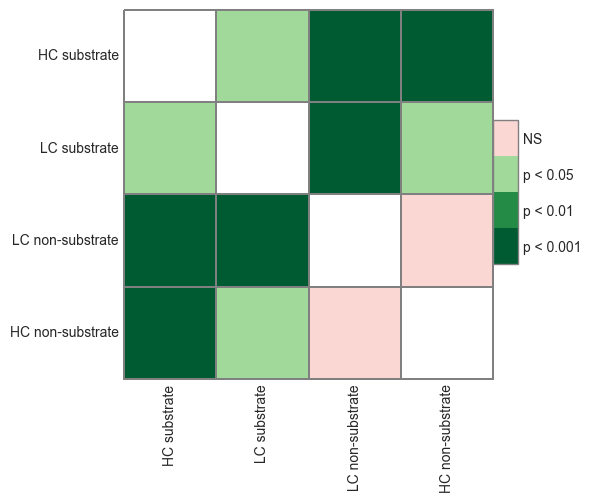

In [646]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_dunn, **heatmap_args)

### Impact difference = Cohen's d ?